<a href="https://colab.research.google.com/github/amitadhainje/MY_NOTES/blob/master/Quora_Question_Pairs_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [9]:
# from google.colab import files
# uploaded = files.upload()

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle competitions download -c quora-question-pairs
! unzip /content/quora-question-pairs.zip
! ls /content

quora-question-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           
kaggle.json		  sample_submission.csv.zip  train.csv.zip
quora-question-pairs.zip  test.csv
sample_data		  test.csv.zip


In [41]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Embedding,LSTM,concatenate
from tensorflow.keras import Input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable,ALL
import warnings
warnings.filterwarnings("ignore")

In [29]:
def DisplayInformation(fieldNames, data):
    infoTable = PrettyTable()
    infoTable.field_names = fieldNames
    infoTable.align='l'
    for x in data:
        infoTable.add_row(x)
    print (infoTable)
    
def DisplayDataframe(data):
    infoTable = PrettyTable()
    infoTable.field_names = data.columns
    infoTable.align='l'
    temp = data.head()
    for index, row in temp.iterrows():
        infoTable.add_row(list(row.values))
    print (infoTable)

In [30]:
df=pd.read_csv('/content/train.csv.zip')
df = df.dropna()
df['question1'] = df['question1'].apply(lambda x:  x.lower())
df['question2'] = df['question2'].apply(lambda x:  x.lower())

print ("\nDISPLAYING THE BASIC INFORMATION ABOUT DATASET - \n")
requiredData = []

requiredFieldNames =  ['DESCRIPTION', 'INFORMATION']
requiredData.append(["Number of Rows",df.shape[0] ])
requiredData.append(["Number of Columns",df.shape[1] ])
requiredData.append(["Input Features", df.columns.values])
requiredData.append(["Target Variable", df.columns.values[-1]])
DisplayInformation(requiredFieldNames, requiredData)

DisplayDataframe(df[['id', 'question1', 'question2']])


DISPLAYING THE BASIC INFORMATION ABOUT DATASET - 

+-------------------+-------------------------------------------------------------+
| DESCRIPTION       | INFORMATION                                                 |
+-------------------+-------------------------------------------------------------+
| Number of Rows    | 404287                                                      |
| Number of Columns | 6                                                           |
| Input Features    | ['id' 'qid1' 'qid2' 'question1' 'question2' 'is_duplicate'] |
| Target Variable   | is_duplicate                                                |
+-------------------+-------------------------------------------------------------+
+----+------------------------------------------------------------------------------+------------------------------------------------------------------------------------------+
| id | question1                                                                    | question2    

In [32]:
dup_df = df[df['is_duplicate'] == 0][0:5456]
non_dup_df = df[df['is_duplicate'] == 1][0:5632]
frames = (dup_df, non_dup_df)
dataset = pd.concat(frames)
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0


In [33]:
dataset.shape

(11088, 6)

In [34]:
%%time

import re
from bs4 import BeautifulSoup

def preprocess(q):
    
    q = str(q).lower().strip()
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    return q

dataset['question1'] = dataset['question1'].apply(preprocess)
dataset['question2'] = dataset['question2'].apply(preprocess)
print ("\nDISPLAYING FEW CLEANED RECORDS OF THE DATASET - \n")
DisplayDataframe(dataset[['question1', 'question2']])


DISPLAYING FEW CLEANED RECORDS OF THE DATASET - 

+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+
| question1                                                                   | question2                                                                               |
+-----------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+
| what is the step by step guide to invest in share market in india           | what is the step by step guide to invest in share market                                |
| what is the story of kohinoor  koh i noor  diamond                          | what would happen if the indian government stole the kohinoor  koh i noor  diamond back |
| how can i increase the speed of my internet connection while using a vpn    | how can internet sp

In [35]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_list1=list(dataset['question1'])
train_list2=list(dataset['question2'])
train_list=train_list1+train_list2

vocab_size=20000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_list)

sequence1=tokenizer.texts_to_sequences(train_list1)
sequence2=tokenizer.texts_to_sequences(train_list2)

#padding the sequences to a constant size
max_length=100
sequence1=pad_sequences(sequence1,maxlen=max_length,padding='post')
sequence2=pad_sequences(sequence2,maxlen=max_length,padding='post')

dataset['seq1']=list(sequence1)
dataset['seq2']=list(sequence2)

labels_df = dataset['is_duplicate']
dataset.head()


CPU times: user 1.6 s, sys: 13 ms, total: 1.61 s
Wall time: 1.84 s


In [36]:
%%time
temp_df1 = pd.DataFrame(list(dataset['seq1'].values)  , columns=list(range(0,100)))
temp_df2 = pd.DataFrame(list(dataset['seq2'].values), columns = list(range(100,200)))
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.head()

CPU times: user 2.29 s, sys: 72.5 ms, total: 2.36 s
Wall time: 2.52 s


In [37]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,2,3,1,1082,62,1082,2805,6,844,8,...,0,0,0,0,0,0,0,0,0,0
1,2,3,1,453,10,6132,6133,5,6134,4079,...,0,0,0,0,0,0,0,0,0,0
2,4,13,5,157,1,441,10,18,362,1632,...,0,0,0,0,0,0,0,0,0,0
3,16,61,5,2315,311,2806,4,13,5,739,...,0,0,0,0,0,0,0,0,0,0
4,24,51,4080,8,237,9130,1846,1460,4916,12,...,0,0,0,0,0,0,0,0,0,0


GradientBoostingClassifier(n_estimators=300, random_state=1)
Following are the evaluation matrices for GradientBoostingClassifier Algorithm - 

+---------------------------+------------------+
|            Name           |      Score       |
+---------------------------+------------------+
|     Training Accuracy     |     84.4479%     |
+---------------------------+------------------+
|      Testing Accuracy     |     81.2744%     |
+---------------------------+------------------+
|          F1 Score         |      0.815       |
+---------------------------+------------------+
|      Precision Score      |      0.8338      |
+---------------------------+------------------+
|        Recall Score       |      0.8127      |
+---------------------------+------------------+


CPU times: user 22.6 s, sys: 97.6 ms, total: 22.7 s
Wall time: 22.5 s


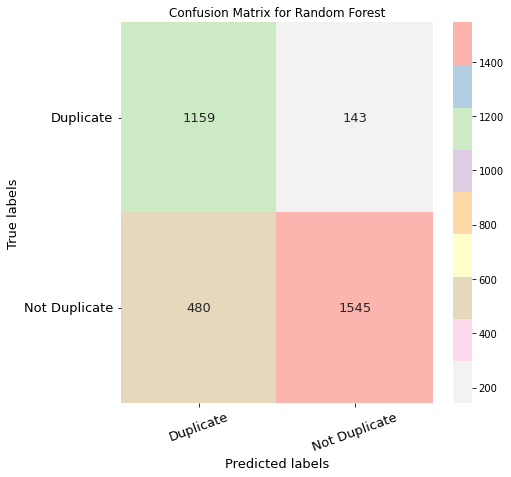

In [42]:
%%time
X = temp_df.values
y = labels_df.values
X_STD = StandardScaler().fit_transform(X)
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=1)

model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=1)
print (model)
model.fit(x_train, y_train)

test_predictedValues = model.predict(x_test)
train_predictedValues = model.predict(x_train)

trainingAccuracyScore = model.score(x_train,y_train) * 100
testingAccuracyScore = model.score(x_test, y_test) * 100
f1Score = f1_score(test_predictedValues, y_test, average='weighted')
precisionScore = precision_score(test_predictedValues, y_test, average='weighted')
recallScore = recall_score(test_predictedValues, y_test, average='weighted')

print ("Following are the evaluation matrices for GradientBoostingClassifier Algorithm - \n")

x = PrettyTable(padding_width=5)
x.hrules=ALL
x.field_names = [" Name ", "Score"]
x.add_row(['Training Accuracy', str((round(trainingAccuracyScore,4)))+'%'])
x.add_row(['Testing Accuracy', str((round(testingAccuracyScore,4)))+'%'])
x.add_row(['F1 Score', str((round(f1Score,4)))])
x.add_row(['Precision Score', str(round(precisionScore, 4))])
x.add_row(['Recall Score', str(round(recallScore, 4))])
print (x)
print ("\n")

conf_mat = confusion_matrix(test_predictedValues, y_test)
df_cm = pd.DataFrame(conf_mat)
classNames = ['Duplicate', 'Not Duplicate']
labels = [0,1]

plt.figure(figsize=(7,7))
ax= plt.subplot()
sns.heatmap(df_cm, annot=True, ax = ax, cmap="Pastel1_r",annot_kws={"size": 13}, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize="13", color='black');
ax.set_ylabel('True labels',fontsize="13",  color='black'); 
ax.set_title('Confusion Matrix for Random Forest'); 
ax.xaxis.set_ticklabels(classNames, rotation=20, fontsize="13", va="top", color='black'); 
ax.yaxis.set_ticklabels(classNames, rotation=0, fontsize="13", va="center", color='black');